# Example usage of 2P dataset in `neuralib.wrapper.rastermap`

- seealso [rastermap](https://github.com/MouseLand/rastermap) and [colab example](https://colab.research.google.com/github/MouseLand/rastermap/blob/main/notebooks/rastermap_largescale.ipynb#scrollTo=E_WTZXx0Io0Y)

In [1]:
from __future__ import annotations
import attrs
import numpy as np
from pathlib import Path

from rastermap import Rastermap
import rastermap.utils

from neuralib.plot import plot_figure, ax_merge
from neuralib.util.util_type import PathLike
from neuralib.wrapper.rastermap import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%load_ext autoreload
%autoreload

### Example of 2P dataset pipeline (suite2p as an example)

In [3]:
# Prepare contrainer for the imaging / behavioral data

@attrs.frozen
class RastermapInput:
    """
    `Dimension parameters`:

        N = number of neurons

        T = number of image pulse

        S = number of stimulation (optional)
        
    """
    
    xy_pos: np.ndarray
    """soma central position (2, N)"""
    neural_activity: np.ndarray
    """(N, T)"""
    image_time: np.ndarray
    """(T,)"""
    position: np.ndarray | None = attrs.field(default=None)
    """(T,)"""
    velocity: np.ndarray | None = attrs.field(default=None)
    """(T,)"""
    lap_index: np.ndarray | None = attrs.field(default=None)
    """(T,)"""
    pupil_area: np.ndarray | None = attrs.field(default=None)
    """(T,)"""
    visual_stim_time: np.ndarray | None = attrs.field(default=None)
    """(S, 2) with on-off stim time"""

    def __attrs_post_init__(self):
        assert self.neural_activity.shape[1] == len(self.position) == len(self.velocity)

    @property
    def n_neurons(self) -> int:
        return self.neural_activity.shape[0]


    @property
    def sampling_rate(self) -> float:
        return 1000 / np.median(np.diff(self.image_time))

    @property
    def x_pos(self) -> np.ndarray:
        return self.xy_pos[0]

    @property
    def y_pos(self) -> np.ndarray:
        return self.xy_pos[1]

    def find_cues_loc(self,
                      time_mask: Optional[np.ndarray] = None, *,
                      to_time: bool = True,
                      tolerance: float = 0.5,
                      cue_loc: tuple[int, ...] = (50, 100)) -> np.ndarray:
        """
        find cue(s) location in index or time domain
        ** Note that the return is relative value (start from zero)
        ** Need to append to get the abs value

        :param time_mask: time mask (T,)
        :param to_time: if True, return value in time domain, else, return indices
        :param tolerance: tolerance for interpolation of position finding the diff
        :param cue_loc:
        :return:
        """
        if time_mask is not None:
            lap_index = self.lap_index[time_mask]
            pos = self.position[time_mask]
        else:
            lap_index = self.lap_index
            pos = self.position

        split_index = np.where(np.diff(lap_index) > tolerance)[0]
        x = np.split(pos, split_index + 1)

        ret = []
        for loc in cue_loc:
            cue_index = [np.searchsorted(it, loc) for it in x]

            # appending index
            for i in range(len(split_index)):
                cue_index[i + 1] += split_index[i]

            ret.append(cue_index)

        ret = np.sort(np.array(ret).ravel())

        if to_time:
            ret = ret / self.sampling_rate

        return ret

    @property
    def visual_stim_start(self) -> float:
        return self.visual_stim_time[0, 0]

    def visual_stim_trange(self, trange: tuple[float, float]) -> np.ndarray:
        """select visual stim time range segments

        :return (nStim, 2)
        """
        vt = self.visual_stim_time  # (N,2) -> (N*2)
        start_idx, end_idx = np.searchsorted(vt.ravel(), list(trange))

        # map to (N, 2)
        start_stim_idx = int(start_idx // 2)
        end_stim_idx = int(end_idx // 2)

        if start_idx % 2 != 0:
            vt[start_stim_idx, 0] = trange[0]

        if end_idx % 2 != 0:
            vt[end_stim_idx, 1] = trange[1]

        return vt[start_stim_idx: end_stim_idx]
    

In [4]:
# Prepare config dict
DEFAULT_2P_RASTERMAP_OPT: RasterOptions = {
    'n_clusters': 50,
    'n_PCs': 128,
    'locality': 0.75,
    'time_lag_window': 5,
    'grid_upsample': 10,
}

In [5]:
def run_rastermap_2p(dat: RastermapInput,
                     suite2p_directory: PathLike,
                     ops: RasterOptions | None = None,
                     neuron_bins: int = 40,
                     **kwargs) -> RasterMapResult:
    if ops is None:
        ops = DEFAULT_2P_RASTERMAP_OPT

    model = Rastermap(
        n_clusters=ops['n_clusters'],
        n_PCs=ops['n_PCs'],
        locality=ops['locality'],
        time_lag_window=ops['time_lag_window'],
        grid_upsample=ops['grid_upsample'],
        **kwargs
    ).fit(dat.neural_activity)

    embedding = model.embedding
    isort = model.isort

    sn = rastermap.utils.bin1d(dat.neural_activity[isort], bin_size=neuron_bins, axis=0)

    # For fit gui launch behavior
    _pseudo_cluster: UserCluster = {
        'ids': np.arange(10),
        'slice': slice(0, 10),
        'binsize': neuron_bins,
        'color': np.array([194.59459459, 255., 0., 50.])
    }

    ret = RasterMapResult(
        filename=str(suite2p_directory / 'F.npy'),
        save_path=str(suite2p_directory),
        isort=isort,
        embedding=embedding,
        ops=ops,
        user_clusters=[_pseudo_cluster],
        super_neurons=sn
    )

    return ret

# ============================== #
# Plot cluster and soma location #
# ============================== #

def plot_rastermap_sort(dat: RastermapInput,
                        raster: RasterMapResult,
                        trange: tuple[int, int],
                        neuron_bins: int = 40):
    """

    :param dat: input data
    :param raster: computed result
    :param trange: time range for visualization
    :return:
    """

    tmask = np.logical_and(trange[0] <= dat.image_time, dat.image_time <= trange[1])
    time = dat.image_time[tmask]


    with plot_figure(None, 10, 20, gridspec_kw={'wspace': 1, 'hspace': 0.3}) as _ax:
        
        # position
        ax1: Axes = ax_merge(_ax)[0, :-1]
        ax1.plot(time, dat.position[tmask], color='k')
        ax1.axis('off')
        ax1.set_title('position')

        # running speed
        ax2: Axes = ax_merge(_ax)[1, :-1]
        ax2.plot(time, dat.velocity[tmask], color='k')
        ax2.axis('off')
        ax2.set_title('running speed')
        ax2.sharex(ax1)

        # superneuron activity
        ax4 = ax_merge(_ax)[2:, :-1]
        ax4.sharex(ax1)
        ax4.imshow(raster.super_neurons[:, tmask],
                   cmap="gray_r",
                   vmin=0,
                   vmax=0.8,
                   aspect="auto",
                   extent=(trange[0], trange[1], dat.n_neurons // neuron_bins, 0))
        ax4.set(xlabel="time(s)", ylabel='superneurons')

        # visual stim
        if dat.visual_stim_start <= trange[1]:
            for v in dat.visual_stim_trange(trange=trange):
                ax4.axvspan(v[0], v[1], color='mistyrose', alpha=0.6)

        # disable
        ax5 = ax_merge(_ax)[:3, -1]
        ax5.axis('off')

        # color bar
        ax6 = ax_merge(_ax)[3:, -1]
        ax6.imshow(np.arange(0, raster.n_super)[:, np.newaxis], cmap="gist_ncar", aspect="auto")
        ax6.axis("off")


def plot_rastermap_2p_soma(dat: RastermapInput,
                           raster: RasterMapResult,
                           output: PathLike | None = None):
    with plot_figure(output) as ax:
        ax.scatter(dat.xy_pos[0],
                   dat.xy_pos[1],
                   s=8, c=raster.embedding, cmap="gist_ncar", alpha=0.25)
        ax.invert_yaxis()
        ax.set(xlabel='X position(mm)', ylabel='Y position(mm)')
        ax.set_aspect('equal')


In [6]:
# Prepare your input data

raster_input = RastermapInput(...)

# raster_input = RastermapInput(
#     xy_pos=cache['xy_pos'],
#     neural_activity=cache['neural_activity'],
#     image_time=cache['image_time'],
#     position=cache['position'],
#     velocity=cache['velocity'],
#     lap_index=cache['lap_index'],
#     # pupil_area=cache['pupil_area'],
#     visual_stim_time=cache['visual_stim_time']
# )

In [7]:
res = run_rastermap_2p(raster_input, ...)

normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.62sec
sorting activity: 1118 valid samples by 108128 timepoints
n_PCs = 128 computed, 8.96sec
33 clusters computed, time 9.17sec
clusters sorted, time 9.49sec
clusters upsampled, time 9.51sec
rastermap complete, time 9.52sec


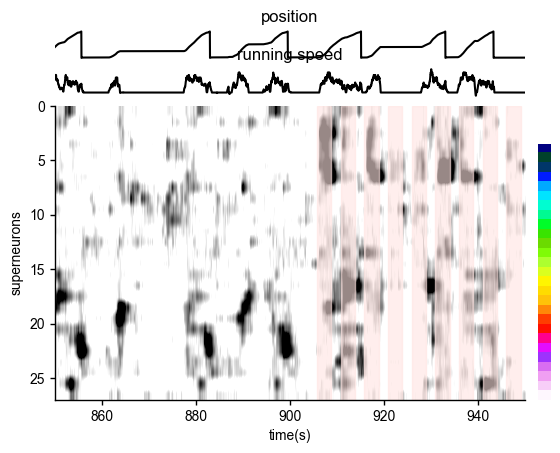

In [10]:
plot_rastermap_sort(raster_input, res, trange=(850, 950))

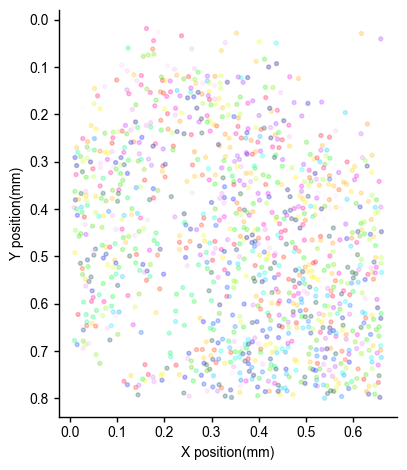

In [9]:
plot_rastermap_2p_soma(raster_input, res)